In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools

comment = "Generate core and sat, load saved realizations and plot"

import pickle

In [2]:
core = SDSS(comment, N_SH = 60, sim_type = "surface", sat_height = 350)

core.grid_glq(nmax = 60, r_at = core.a)

grid_in = np.array([core.grid_glq_phi, 90-core.grid_glq_theta]).T
core.make_grid(core.a, grid_in, calc_sph_d = True)

core.generate_map()

#core.condtab(normsize=10000)
core.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 5, zero_nugget = True)

____semi-variogram setup___

Number of data used: 54478193
Max data distance: 19996.320 km
Lag length chosen: 5.0 km
Number of lags: 3999
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation



In [4]:
s_sat = SDSS(comment, N_SH = 60, sim_type = "surface", sat_height = 350)

s_sat.load_swarm("ABC")

grid_in = np.array([s_sat.swarm_phi, 90-s_sat.swarm_theta]).T
s_sat.make_grid(s_sat.swarm_radius, grid_in, calc_sph_d = False)

s_sat.generate_map(grid_type = "swarm")


Gauss-Legendre RMSE:	 0.026


<IPython.core.display.Javascript object>


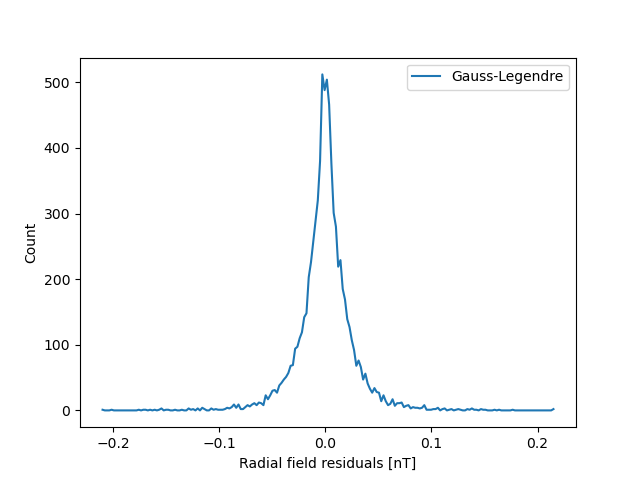

(7978, 7381)
(7978, 7381)
(7978, 7978)


In [5]:
G_r = mt_util.Gr_vec(core.r_grid, s_sat.r_grid, core.lat, s_sat.lat, core.lon, s_sat.lon)
G_d = np.pi/(core.grid_glq_nmax+0.5)*np.multiply(core.grid_glq_w,G_r) # +0.5 for parity with SHTOOLS

errorstd = 0.1
errorvar = errorstd**2

def covmod_lsq_equiv(obs,semivar,target_var,G_d,title="",errorvar = 10e2):
    a_0 = np.empty([0,])
    b_0 = obs
    d_0 = b_0

    G = G_d.copy()
    C_M = target_var - semivar
    C_D = np.zeros((len(a_0)+len(b_0),len(a_0)+len(b_0)))
    C_D[np.arange(len(a_0)+1,len(a_0)+len(b_0)),np.arange(len(a_0)+1,len(a_0)+len(b_0))] = errorvar
    S = C_D + G*C_M*G.T
    T = np.linalg.inv(S)
    m_equiv_lsq = C_M*G.T*T*d_0
    lsq_equiv_pred = G_d*m_equiv_lsq
    lsq_equiv_res = obs - lsq_equiv_pred
    return m_equiv_lsq, lsq_equiv_pred, lsq_equiv_res

m_equiv_lsq, lsq_equiv_pred, lsq_equiv_res = covmod_lsq_equiv(s_sat.data.reshape(-1,1),core.sv_lut,core.target_var,G_d,title="Gauss-Legendre equivalent LSQ solution",errorvar = errorvar)

# RMSE
rmse_leg = np.sqrt(np.mean(np.power(lsq_equiv_res,2)))
print("")
print("Gauss-Legendre RMSE:\t %0.3f" %rmse_leg)
plt.figure()
y,binEdges=np.histogram(lsq_equiv_res,bins=200)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'C0',label="Gauss-Legendre")
plt.xlabel("Radial field residuals [nT]")
plt.ylabel("Count")
plt.legend()
plt.show()

#%% GREENS CORE
print(G_d.shape)
G_k = G_d*(core.target_var-core.sv_lut)
print(G_k.shape)
GG_K = G_k*G_d.T  + np.diag(errorvar*np.ones(s_sat.swarm_N,))
print(GG_K.shape)
sort_support = np.flipud(np.argsort(G_k,axis=0))
idx_data_support = sort_support

In [281]:
core.zs = np.load("zs_nb_sh_lithosphere_swarm_ABC_sh60_chosolve_z7.npy")
core.zs = core.zs[:,:8]

In [282]:
core.zs.shape

(7381, 8)

In [283]:
core.zs[:,-1]

array([-14.20166408, -13.7666676 ,  -6.68925226, ...,   0.61359729,
         0.96170577,  -0.0236218 ])

In [292]:
core.grid_glq(nmax = 60, r_at = core.a)

In [284]:
N_sim = core.zs.shape[1]


Seqsim RMSE:	 [[0.07143597 0.06955426 0.0693537  0.0697772  0.07238145 0.06976118
  0.07362211 0.0707235 ]]


<IPython.core.display.Javascript object>


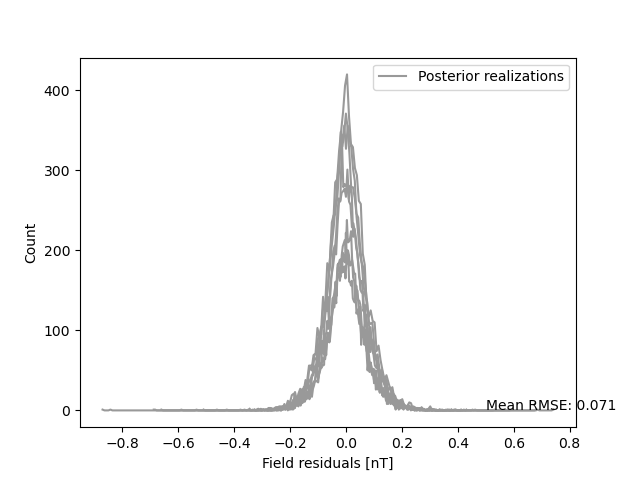

In [286]:
seqsim_pred = G_d*core.zs
seqsim_res = s_sat.data.reshape(-1,1) - seqsim_pred
seqsim_res_mean = np.mean(seqsim_res,axis=1)

rmse_leg = np.sqrt(np.mean(np.power(seqsim_res,2),axis=0))
print("")
print("Seqsim RMSE:\t {}".format(rmse_leg))

color_rgb = (0.6,0.6,0.6)
plt.figure()

for i in np.arange(0,N_sim):
    y,binEdges=np.histogram(seqsim_res[:,[i]],bins=200)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    if i == 0:
        plt.plot(bincenters,y,'-',color = color_rgb,label='Posterior realizations')  
    else:
        plt.plot(bincenters,y,'-',color = color_rgb)  

#y,binEdges=np.histogram(seqsim_res_mean,bins=200)
#bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
#plt.plot(bincenters,y,'--',color = "black",label='Mean') 
plt.text(0.5, 0.5, "Mean RMSE: {:.3f}".format(np.mean(rmse_leg)))
plt.xlabel("Field residuals [nT]")
plt.ylabel("Count")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


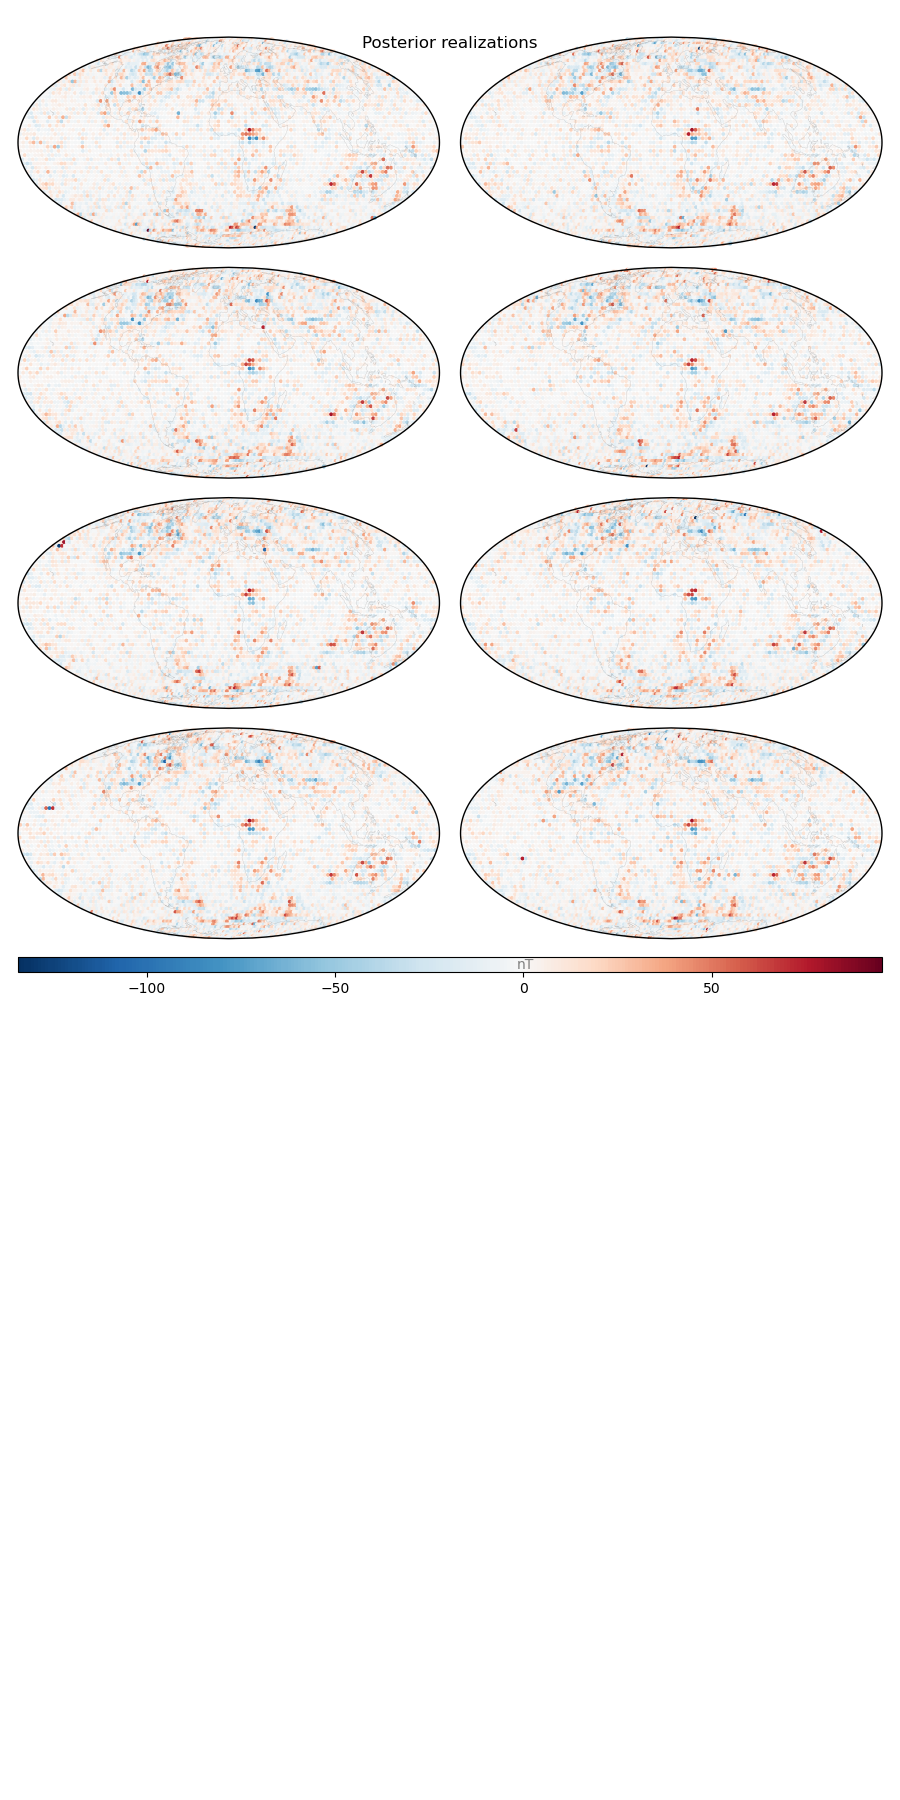

In [290]:
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.lon, core.lat, core.zs, tile_size_row = 4, tile_size_column = 2,
                        figsize=(9,18), limit_for_SF = 10**6, point_size = 3,
                        left=0.02, bottom=0.46, right=0.98, top=0.98, wspace = 0.05, hspace=0.1, 
                        savefig = False, save_string = "test", 
                        projection = ccrs.Mollweide())

In [293]:
core.g_spec = []

for i in np.arange(0,N_sim):

    C_cilm = pyshtools.expand.SHExpandGLQ(core.zs[:,[i]].reshape(core.grid_glq_nmax+1,2*core.grid_glq_nmax+1), core.grid_glq_w_shtools, core.grid_glq_zero, [2, 1, core.grid_glq_nmax])
    nm_C = mt_util.array_nm(core.grid_glq_nmax)

    C_corr_sh = 1/(nm_C[:,[0]]+1)*1/(core.a/core.a)**(nm_C[:,[0]]+2)
    
    C_index = np.transpose(pyshtools.shio.SHCilmToCindex(C_cilm))
    C_index = C_index[1:,:]*C_corr_sh

    C_vec = mt_util.gauss_vector(C_index, core.grid_glq_nmax, i_n = 0, i_m = 1)
    
    core.g_spec.append(C_vec)

core.g_spec = np.array(core.g_spec).T
print(core.g_spec.shape)

(3720, 8)


In [294]:
core.g_spec[:3,:10]

array([[0.09055695, 0.05197508, 0.08189149, 0.10666728, 0.07665258,
        0.05781405, 0.10189614, 0.07060693],
       [0.02554516, 0.02942659, 0.04329369, 0.03447364, 0.03180592,
        0.04647307, 0.03171705, 0.03363179],
       [0.01835237, 0.01073145, 0.0227959 , 0.0141333 , 0.02504599,
        0.01799121, 0.01697541, 0.00553201]])

In [295]:
core.g_prior[:3]

array([0.052715, 0.038312, 0.026969])

<IPython.core.display.Javascript object>


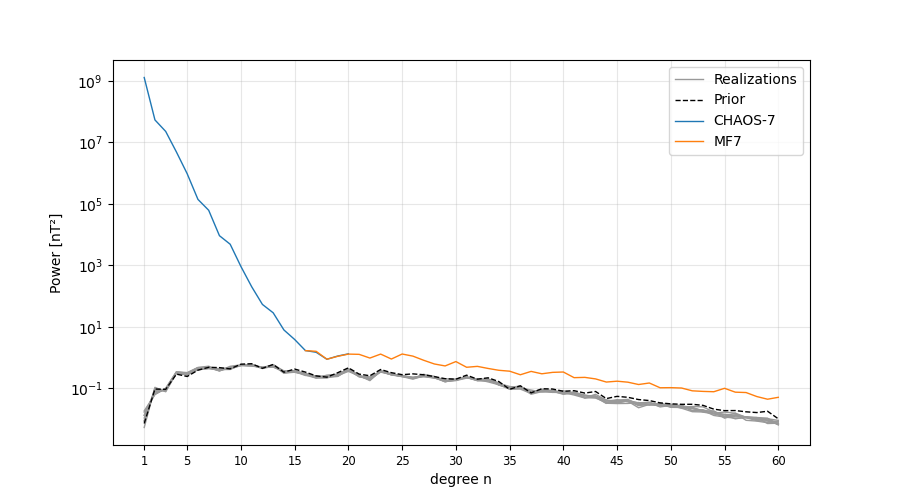

In [296]:
g_spec_compares = core.g_prior
model_dict = {"CHAOS-7", "MF7"}
labels = ["Realization"]

mt_util.plot_p_spec(core.g_spec, core.r_sat, core.N_SH, spec_style = "ensemble",
                    g_spec_compares = g_spec_compares,
                    model_dict = model_dict, label = "Realizations", label_compare = "Prior",
                    lwidth = 1, lwidth_m = 1, figsize = (9,5), color = (0.6, 0.6, 0.6))

In [311]:
#core.grid_equal_area(N_grid = 15020, r_at = core.a, poles_remove = True)

#core.ensemble_B(core.g_spec, nmax = core.grid_glq_nmax, r_at = core.a, grid_type = "eqa")
#zs_eqa = core.B_ensemble_eqa[:,0,:].copy()

#core.ensemble_B(g_spec_compares[:mt_util.shc_vec_len(core.grid_glq_nmax)], nmax = core.grid_glq_nmax, r_at = core.a, grid_type = "eqa")
#prior_eqa = core.B_ensemble_eqa[:,0].copy()


core.grid_glq(nmax = 120, r_at = core.a)

core.ensemble_B(core.g_spec, nmax = 60, r_at = core.a, grid_type = "glq")
zs_eqa = core.B_ensemble_glq[:,0,:].copy()

core.ensemble_B(g_spec_compares[:mt_util.shc_vec_len(core.grid_glq_nmax)], nmax = 60, r_at = core.a, grid_type = "glq")
prior_eqa = core.B_ensemble_glq[:,0].copy()



<IPython.core.display.Javascript object>


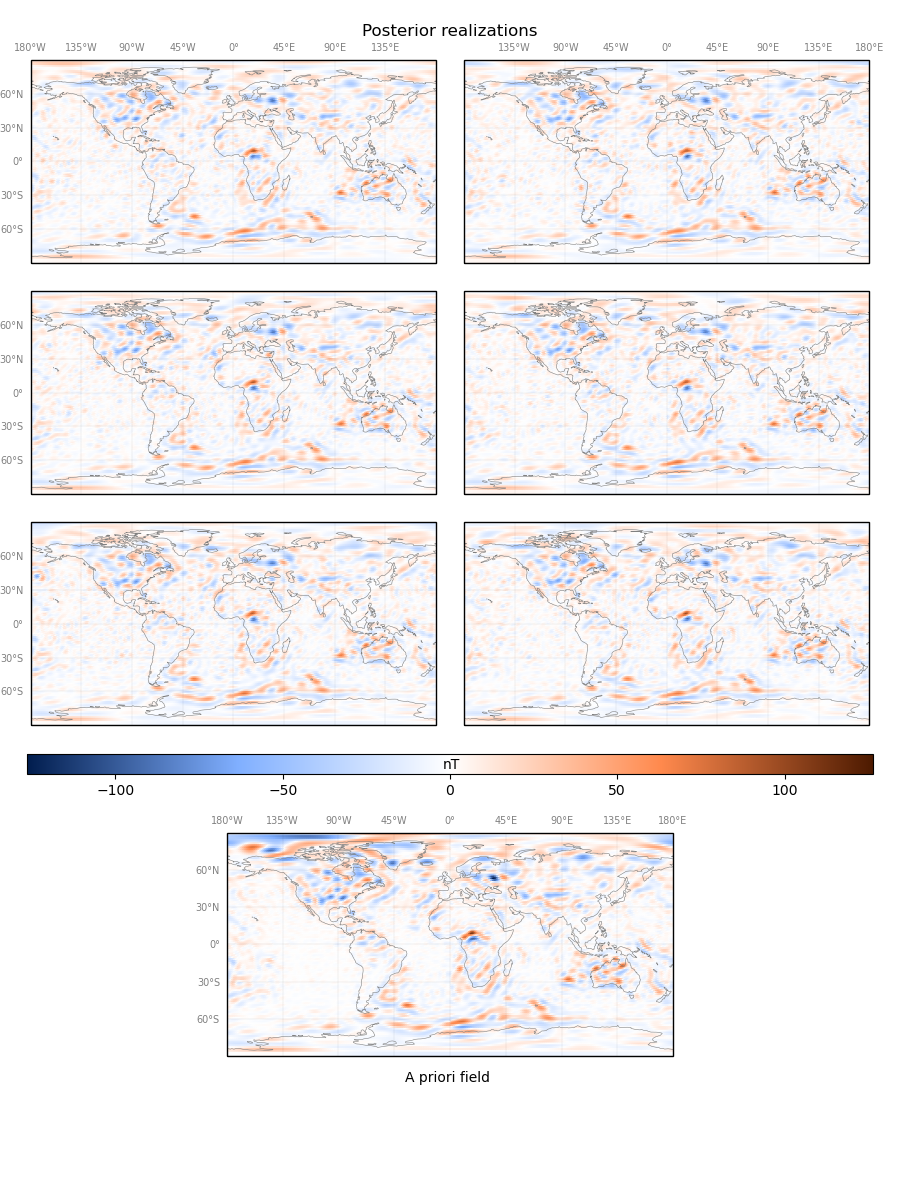

In [333]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

#mt_util.plot_ensemble_map_tiles(core.grid_eqa_phi, 90-core.grid_eqa_theta, zs_eqa, 
mt_util.plot_ensemble_map_tiles(core.grid_glq_phi, 90-core.grid_glq_theta, zs_eqa, 
                        field_compare = prior_eqa, tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 10,
                        coast_width = 0.4, coast_color = "grey",
                        cbar_h = 0.1, cbar_text = "nT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.2, 
                        savefig = False, save_string = "lithos_ABC_sh60", 
                        projection = ccrs.PlateCarree(), use_gridlines = True, 
                        gridlines_width = 0.2, gridlines_alpha = 0.2, save_dpi = 100)


#mt_util.plot_cartopy_global(lat = 90-core.grid_eqa_theta, lon = core.grid_eqa_phi, plot_quality = "high", 
#                            data=prior_eqa, limits_data = core.data, point_size=8, 
#                            scale_uneven = True, cmap = plt.cm.RdBu_r, figsize=(7,8), 
#                            title="Prior radial core information", norm_class = "midpoint")

<IPython.core.display.Javascript object>


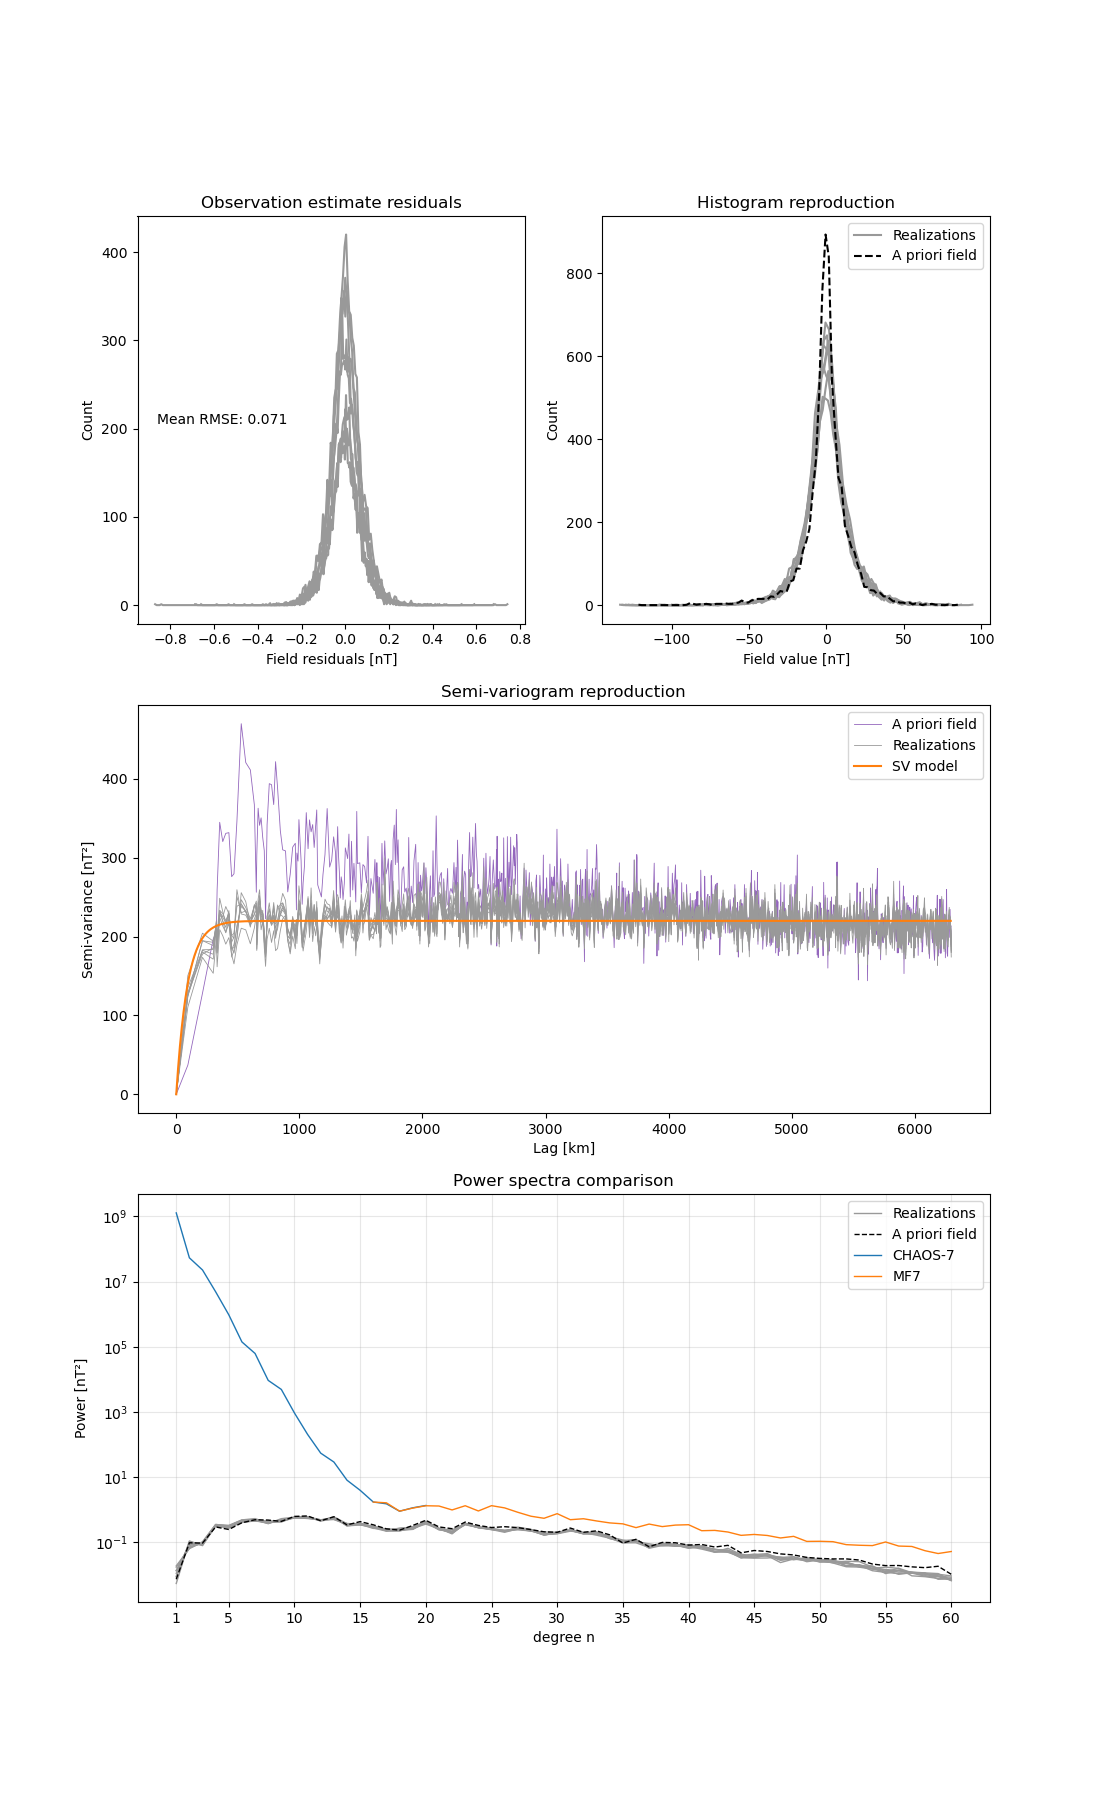

In [309]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = 60, r_at = core.a)

mt_util.plot_sdssim_reproduce(core, seqsim_res, lags_use = 1000, spec_r_at = core.r_sat,
                              model_dict = {"CHAOS-7", "MF7"}, figsize=(11,18),
                              savefig = False, save_string = "lithos_ABC_sh60")

In [38]:
#mt_util.plot_cartopy_animation(lat = 90-core.grid_eqa_theta, lon = core.grid_eqa_phi, limits_data = core.B_ensemble_eqa[:,0,0], data=core.B_ensemble_eqa[:,0,:], animation_quality = "high", frames = 99, interval = 24, point_size = 10)